### Library

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Module
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import ssl
import os
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Download Path

In [3]:
Download_DataPath = os.path.join(os.getcwd(),'Data')

### Load  - Transoform - Normalize MINST Dateset

#### Data Augmentation

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((32, 32)) ,
    transforms.RandomHorizontalFlip(), # Augmenetaion Flib Images
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees = 0, shear = 10, scale = (0.5, 1.2)),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [5]:
transform = transforms.Compose([transforms.Resize((32, 32)) ,transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.CIFAR10(root = Download_DataPath, train = True, transform = transform_train, download = True)
validation_dataset = datasets.CIFAR10(root = Download_DataPath, train = False, transform = transform, download = True)

Files already downloaded and verified
Files already downloaded and verified


### Prepare - Shuffle Data Batches

In [6]:
training_loader = DataLoader(dataset = training_dataset, shuffle = True, batch_size = 100)
validation_loader = DataLoader(dataset = validation_dataset, shuffle = True, batch_size = 100)

#### Transofrom Tesnor Image
- Tensor Image Of Shape (1, 28, 28) to (28, 28, 1)
- Remove Normalization
- Set Value Range From 0 -> 1 Instead Of -1 -> 1

In [7]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # Get Clone From The Tensor And Transfer To Numpy Array
    image = image.transpose(1, 2, 0) # Fix ARray Shape From (1, 28, 28) to (28, 28, 1) To Be Feeded Well To The Network ( Model )
    #print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # Remove Normalization
    image = image.clip(0, 1) # Clip Every -1 to 0 and Every 1 to 1 In The Array
    return image

### Load Data In Batches

In [8]:
dataIter = iter(training_loader) # Move Through Data Batches 
images, labels = next(dataIter) #( Load Batche One By One Mean Load Every 100 Image )

In [9]:
valdataIter = iter(validation_loader) # Move Through Data Batches 
vimages, vlabels = next(valdataIter) #( Load Batche One By One Mean Load Every 100 Image )

### Plot First 20 Image

In [10]:
training_classes = list(training_dataset.classes)

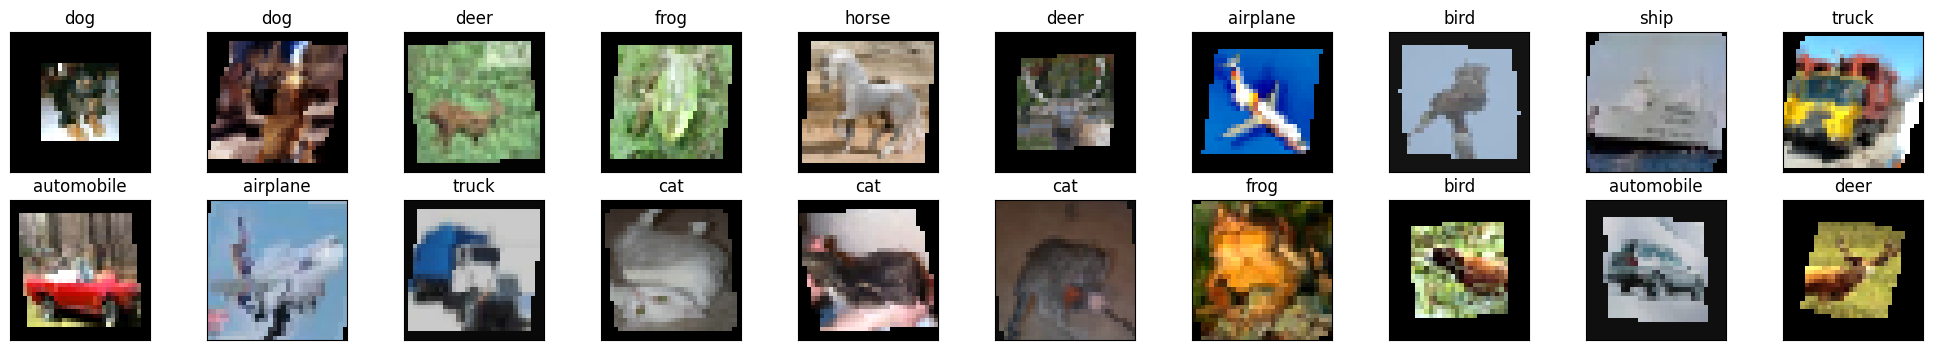

In [11]:
fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    #ax.set_title(labels[idx].item())
    ax.set_title(training_classes[labels[idx].item()])

In [12]:
validtion_classes = list(validation_dataset.classes)

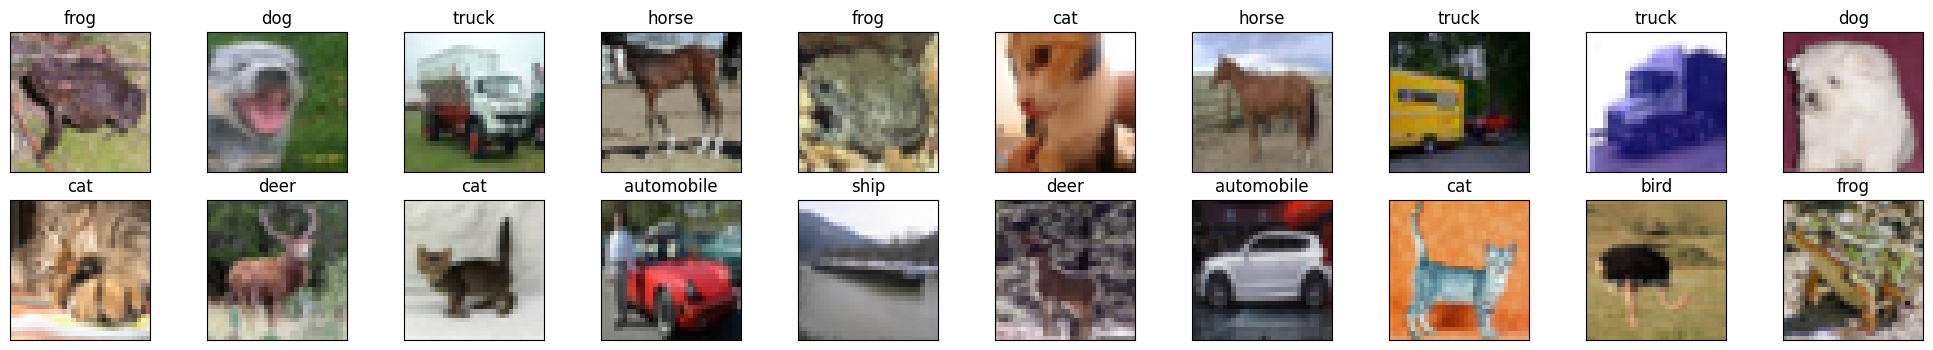

In [13]:
fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(vimages[idx]))
    #ax.set_title(vlabels[idx].item())
    ax.set_title(validtion_classes[vlabels[idx].item()])

### Create Model

In [14]:
class LeNetCNNImageClassifier(Module):
    def __init__(self):
        super().__init__()
                                         # RGB 3 Channel
        # 32 -> 28  { (  (n + 2p - f) / s)  + 1 } = ((32 + 2*0 - 5) / 1) + 1   (28) After That apply max2pool ( divid by 2 ) it will be 14
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1) 
        # 14 -> 10  { (  (n + 2p - f) / s)  + 1 } = ((14 + 2*0 - 5) / 1) + 1 (10) After That apply max2pool ( divid by 2 ) it will be 5
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
         # 14 -> 10  { (  (n + 2p - f) / s)  + 1 } = ((14 + 2*0 - 5) / 1) + 1 (10) After That apply max2pool ( divid by 2 ) it will be 5
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        
        self.fc1 = nn.Linear(in_features = 4*4*64, out_features = 500) # input ( 5 * 5 * 50 )
        self.dropout= nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(in_features = 500, out_features = 10)
    def forward(self, x):
        # Conv => Relu => Bool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size = 2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size = 2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size = 2, stride=2)
        x = x.view(-1, 4*4*64)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [15]:
model = LeNetCNNImageClassifier()

In [16]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.1113, -0.0061, -0.0337],
                        [-0.1619,  0.1041, -0.0755],
                        [-0.1177, -0.1715, -0.0419]],
              
                       [[ 0.0900,  0.0274,  0.0303],
                        [-0.0938,  0.0173,  0.1675],
                        [-0.0435,  0.1405, -0.0374]],
              
                       [[ 0.1602, -0.0451, -0.0896],
                        [ 0.0205, -0.0295, -0.0415],
                        [ 0.0455, -0.0046,  0.0588]]],
              
              
                      [[[ 0.0138, -0.0319,  0.0429],
                        [-0.0399,  0.0937, -0.1142],
                        [ 0.1790,  0.1898,  0.0840]],
              
                       [[-0.0601, -0.0778,  0.0511],
                        [-0.1645, -0.1889,  0.0710],
                        [-0.1643, -0.1499, -0.0747]],
              
                       [[-0.0757, -0.1360,  0.1381],
                        [ 

In [17]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Linear: 1-4                            512,500
├─Dropout2d: 1-5                         --
├─Linear: 1-6                            5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Linear: 1-4                            512,500
├─Dropout2d: 1-5                         --
├─Linear: 1-6                            5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0

### Loss Function , Optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

### Train The Model

In [19]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    val_running_loss = 0.0
    val_running_correct = 0.0
    for inputs, labels in training_loader:
        # inputs = inputs.view(inputs.shape[0], -1) #(100, 784 = 28*28)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1) # max score from outputs scores [0 -> 1] Cross Entropy with softmax
        running_loss += loss.item() # the current loss at the batch iteration
        running_correct += torch.sum(pred == labels.data)
    else:
        with torch.no_grad():
          for val_inputs, val_labels in validation_loader:
            # val_inputs = val_inputs.view(val_inputs.shape[0], -1) #(100, 784 = 28*28)
            val_outputs = model(val_inputs)          
            val_loss = criterion(val_outputs, val_labels)

            _, val_pred = torch.max(val_outputs, 1) # max score from outputs scores [0 -> 1] Cross Entropy with softmax
            val_running_loss += val_loss.item() # the current loss at the batch iteration
            val_running_correct += torch.sum(val_pred == val_labels.data)

            val_epoch_loss = val_running_loss / len(validation_loader) # avg epoch loss
            val_epoch_acc = val_running_correct.float() / len(validation_loader) # avg epoch accuracy
            val_running_loss_history.append(val_epoch_loss)
            val_running_correct_history.append(val_epoch_acc)

        
        epoch_loss = running_loss / len(training_loader) # avg epoch loss
        epoch_acc = running_correct.float() / len(training_loader) # avg epoch accuracy
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)
        
        print(f'Epoch {epoch}')
        print('epoch loss {:.4f},   epoch accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation epoch loss {:.4f},   validation epoch accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))        


Epoch 0
epoch loss 1.7085,   epoch accuracy 37.0700
validation epoch loss 1.3958,   validation epoch accuracy 48.9200
Epoch 1
epoch loss 1.4121,   epoch accuracy 48.8540
validation epoch loss 1.2919,   validation epoch accuracy 53.3900
Epoch 2
epoch loss 1.2955,   epoch accuracy 53.4660
validation epoch loss 1.1171,   validation epoch accuracy 60.0800
Epoch 3
epoch loss 1.1953,   epoch accuracy 57.2920
validation epoch loss 1.0462,   validation epoch accuracy 62.7000
Epoch 4
epoch loss 1.1228,   epoch accuracy 59.9000
validation epoch loss 0.9790,   validation epoch accuracy 65.1600
Epoch 5
epoch loss 1.0664,   epoch accuracy 62.3320
validation epoch loss 0.9287,   validation epoch accuracy 67.2800
Epoch 6
epoch loss 1.0208,   epoch accuracy 63.7780
validation epoch loss 0.8625,   validation epoch accuracy 69.5200
Epoch 7
epoch loss 0.9795,   epoch accuracy 65.1860
validation epoch loss 0.8389,   validation epoch accuracy 70.2100
Epoch 8
epoch loss 0.9494,   epoch accuracy 66.2360
vali

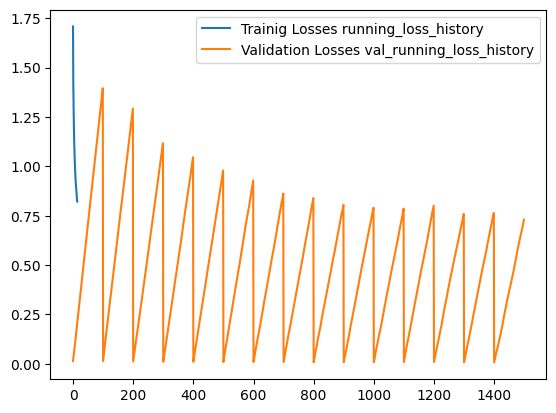

In [34]:
plt.plot(running_loss_history, label = 'Trainig Losses running_loss_history')
plt.plot(val_running_loss_history, label = 'Validation Losses val_running_loss_history')
plt.legend()
plt.show()

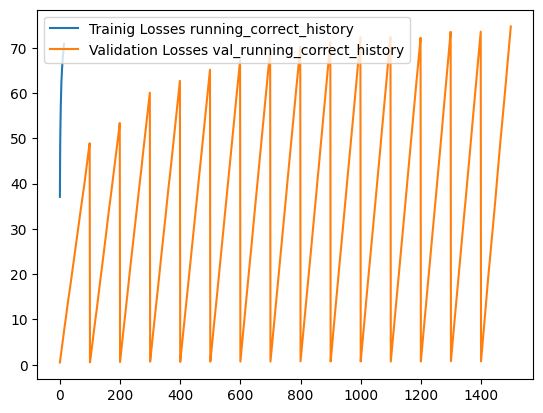

In [35]:
plt.plot(running_correct_history, label = 'Trainig Losses running_correct_history')
plt.plot(val_running_correct_history, label = 'Validation Losses val_running_correct_history')
plt.legend()
plt.show()

#### Test Model

In [36]:
import requests
import PIL.ImageOps
import PIL 
from PIL import Image

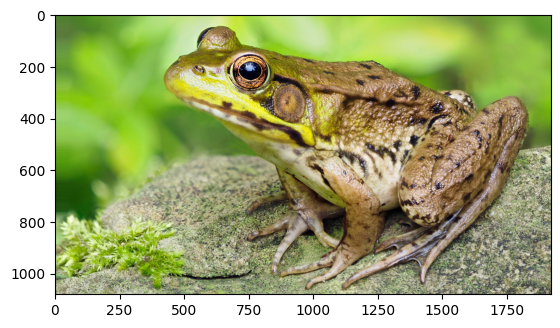

In [47]:
url = "https://fox8.com/wp-content/uploads/sites/12/2023/10/frog.jpg"
response = requests.get(url, stream = True)
if response:
    img = Image.open(response.raw)
    plt.imshow(img)

## Image Processing
#### Image To be Feeded Must be Black white and black color 

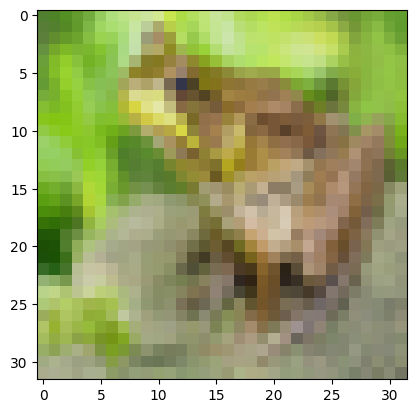

In [48]:
# img = PIL.ImageOps.invert(img.convert('RGB'))
# img =img.convert(mode ="L")
img = transform(img)
plt.imshow(im_convert(img))

#### Prediction

In [49]:
# img = img.view(img.shape[0], -1) #(100, 784 = 28*28)
outputs = model(img)
_, pred = torch.max(outputs, 1)
print(training_classes[pred.item()])

frog


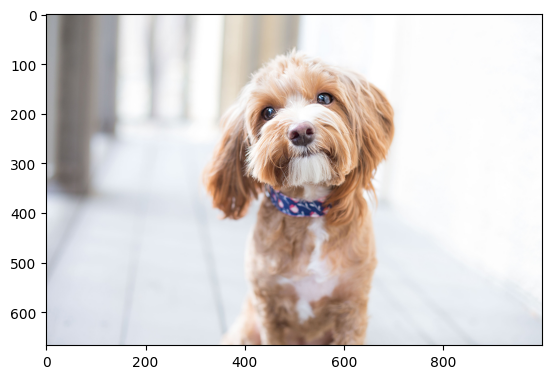

In [50]:
url = "https://www.cdc.gov/healthypets/images/pets/cute-dog-headshot.jpg"
response = requests.get(url, stream = True)
if response:
    img = Image.open(response.raw)
    plt.imshow(img)

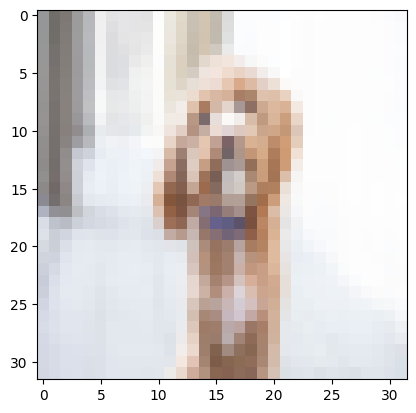

In [51]:
# img = PIL.ImageOps.invert(img.convert('RGB'))
# img =img.convert(mode ="L")
img = transform(img)
plt.imshow(im_convert(img))

In [52]:
# img = img.view(img.shape[0], -1) #(100, 784 = 28*28)
outputs = model(img)
_, pred = torch.max(outputs, 1)
print(training_classes[pred.item()])

dog


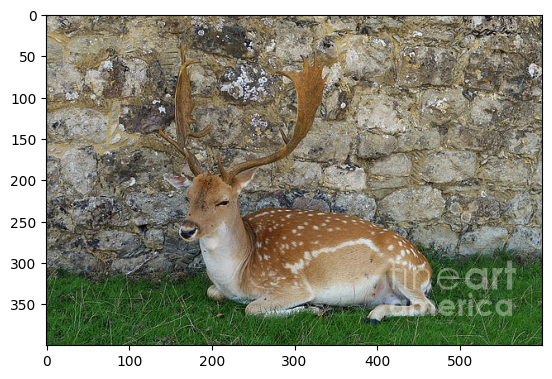

In [56]:
url = "https://images.fineartamerica.com/images/artworkimages/medium/1/fallow-deer-resting-kevin-richardson.jpg"
response = requests.get(url, stream = True)
if response:
    img = Image.open(response.raw)
    plt.imshow(img)

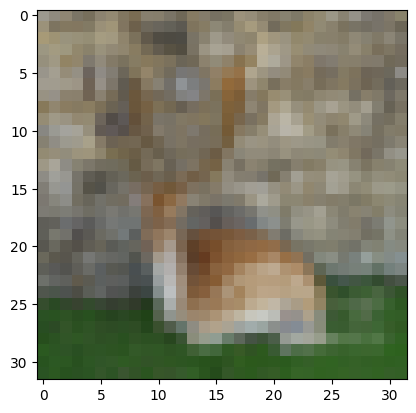

In [57]:
# img = PIL.ImageOps.invert(img.convert('RGB'))
# img =img.convert(mode ="L")
img = transform(img)
plt.imshow(im_convert(img))

In [58]:
# img = img.view(img.shape[0], -1) #(100, 784 = 28*28)
outputs = model(img)
_, pred = torch.max(outputs, 1)
print(training_classes[pred.item()])

deer


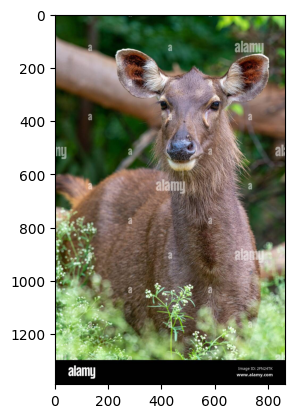

In [59]:
url = "https://c8.alamy.com/comp/2FN24TK/hornless-sambar-deer-walking-and-grazing-through-the-grass-land-in-tamil-nadu-2FN24TK.jpg"
response = requests.get(url, stream = True)
if response:
    img = Image.open(response.raw)
    plt.imshow(img)

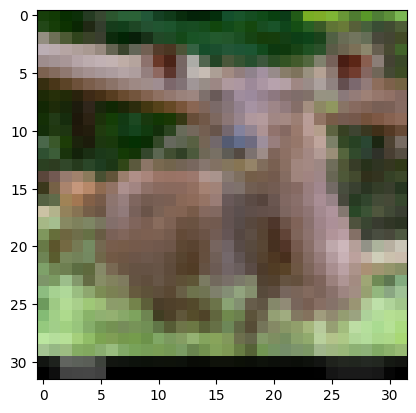

In [60]:
# img = PIL.ImageOps.invert(img.convert('RGB'))
# img =img.convert(mode ="L")
img = transform(img)
plt.imshow(im_convert(img))

In [61]:
# img = img.view(img.shape[0], -1) #(100, 784 = 28*28)
outputs = model(img)
_, pred = torch.max(outputs, 1)
print(training_classes[pred.item()])

deer


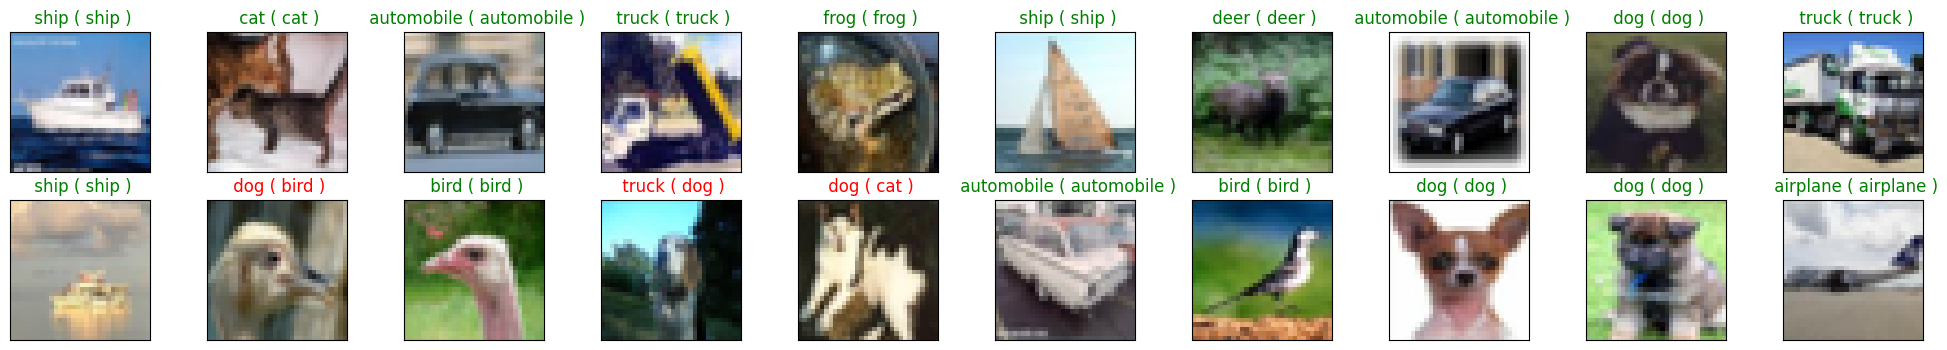

In [64]:
valdataIter = iter(validation_loader)
images, labels = next(valdataIter)
# images = images.view(images.shape[0], -1)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f' {str(validtion_classes[preds[idx].item()])} ( {str(validtion_classes[labels[idx].item()])} )', color = ('green' if preds[idx] == labels[idx] else 'red'))